ADD COLAB BADGE (kida) 

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows
!unzip ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip -d dataset
!rm ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip

In [2]:
import csv
import hashlib
import os
import pathlib
import pickle
import random
import re
import string
import timeit
import unicodedata
from collections import defaultdict
from itertools import combinations
from typing import Callable, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import torch
import torch.nn.functional as F
from scipy.optimize import fsolve
from scipy.stats import kendalltau, spearmanr
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel

In [3]:
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm', exclude=['parser', 'ner'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Implementation

## Hash utils

In [4]:
def is_prime(n: int):
    if n < 2:
        return False
    for i in range(2, int(np.sqrt(n))+1):
        if (n % i) == 0:
            return False
    return True

def find_closest_prime(n):
    while True:
        if is_prime(n):
            return n
        n += 1

def get_variable_length_hash(n: int):
    def inner_f(s: str):
        binary_str = bin(
            int.from_bytes(
                hashlib.sha256(s.encode()).digest(), 
                'little'
            )
        )[-n:]
        return int(binary_str, 2)
    return inner_f

class HashGenerator:
    def __init__(
        self, 
        num_rows: int, 
    ) -> None:
        self.num_rows = num_rows
        self.prime = find_closest_prime(num_rows)
        self.a_set = set()
        self.b_set = set()

    def get_num_rows(self) -> int:
        return self.num_rows

    def next(self) -> Callable[[np.uint32], np.uint32]:
        a = self._generate_coeff(self.a_set, self.num_rows)
        b = self._generate_coeff(self.b_set, self.num_rows)
        return lambda row: np.uint32((a * row + b) % self.prime)

    def reset(self) -> None:
        self.a_set = set()
        self.b_set = set()

    def _generate_coeff(
        self, 
        coeff_set: set[int],
        max_val: int
    ) -> int:
        while True:
            coeff = random.randint(1, max_val)
            if coeff not in coeff_set:
                coeff_set.add(coeff)
                return coeff
    

## Preprocessing utils

In [5]:
def normalize_white_space(doc: str) -> str:
    return " ".join(doc.split())

def remove_https(doc: str) -> str:
    return re.sub(r'https?://[^ ]+', '', doc)

def replace_chars(doc: str) -> str:
    return doc.replace('&amp;', ' and ')

def remove_non_ascii(doc: str) -> str:
    """We keep cyrillic characters due to the nature
    of the dataset.
    """
    cyr_chars = "АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя"

    res = ""
    for c in doc:
        if (c.isascii() and c.isprintable()) \
            or (c in cyr_chars) or c.isspace():
            res += c
    return res

def strip_accents(doc: str) -> str:
    """Replace words with accent with their 
    counterpart without accent. Also deal with 
    special characters such as 𝕒, 𝕕, 𝕖, 𝙖, 𝙘, 𝙙. 
    """
    return unicodedata.normalize('NFKD', doc)

def strip_punctuation(doc: str) -> str:
    return re.sub('[' + re.escape(string.punctuation) + ']', '', doc)
    
def get_lemmatizer( 
    nlp: spacy.pipeline, 
    allow_stop_words: bool = False,
    allow_punct: bool = False,
    allow_numbers: bool = False
) -> Callable[[str], str]:
    def inner_f(doc):
        return ' '.join(
            [
                token.lemma_
                for token in nlp(doc)
                if (not token.is_stop or allow_stop_words) \
                    and (not token.is_punct or allow_punct) \
                    and (token.pos_ != 'NUM' or allow_numbers) \
                    and (not token.pos_ == 'X')
            ]
        )
    return inner_f

## Model

In [36]:
def jaccard_similarity(
    x: np.ndarray, 
    y: np.ndarray
) -> float:
    numerator = len(set(x).intersection(set(y)))
    denominator = len(set(x).union(set(y)))
    return numerator / denominator

class LSHModel:
    def __init__(
        self,
        k: int,
        threshold: float,
        num_hashes: int,
        shingle_hash_bits: int,
        track_shingles: bool = False,
        checkpoint_path: Optional[str] = None
    ) -> None:
        self.k = k
        self.threshold = threshold
        self.num_hashes = num_hashes
        self.shingle_set = set()
        self.char_set = set()
        self.shingle_hash_bits = shingle_hash_bits
        self.shingle_hash = get_variable_length_hash(
            shingle_hash_bits
        )
        self.num_shingles = 2 ** shingle_hash_bits
        self.track_shingles = track_shingles
        self.checkpoint_path = checkpoint_path
        self.num_docs = 0
        self.docs_dict = dict()
        self.signature = None
        self.candidate_pairs = set()
        self.fp_pairs = set()
        self.similar_pairs = set()
        self.b = -1
        self.r = -1
        self.sig_idx = -1

        if self.num_hashes > self.num_shingles:
            raise ValueError(
                f"Number of hash functions must be lower than "
                f"or equal to the number of shingles. Found "
                f"{self.num_hashes} hash functions and "
                f"{self.num_shingles} shingles."
            )

    def load_checkpoint(
        self,
        checkpoint_path: Optional[str] = None
    ) -> None:
        if checkpoint_path is not None:
            self.checkpoint_path = checkpoint_path
        if self.checkpoint_path is None:
            raise ValueError(
                "Checkpoint path not found"
            )
        else:
            tup_ls = [
                (f'{self.checkpoint_path}/docs_dict.npy', 'docs_dict'),
                (f'{self.checkpoint_path}/shingle_set.npy', 'shingle_set'),
                (f'{self.checkpoint_path}/char_set.npy', 'char_set'),
                (f'{self.checkpoint_path}/signature.npy', 'signature'),
                (f'{self.checkpoint_path}/sig_idx.npy', 'sig_idx'),
                (f'{self.checkpoint_path}/candidate_pairs.npy', 'candidate_pairs'),
                (f'{self.checkpoint_path}/fp_pairs.npy', 'fp_pairs'),
                (f'{self.checkpoint_path}/similar_pairs.npy', 'similar_pairs')
            ]

            for file_path, attr in tup_ls:
                if os.path.isfile(file_path):
                    if attr in ['signature']:
                        setattr(
                            self, 
                            attr, 
                            np.load(file_path, allow_pickle=True)
                        )
                    else:
                        setattr(
                            self, 
                            attr, 
                            np.load(file_path, allow_pickle=True).item()
                        )
                        
    def save_checkpoint(
        self,
        checkpoint_path: Optional[str] = None
    ) -> None:
        if checkpoint_path is not None:
            self.checkpoint_path = checkpoint_path
        if self.checkpoint_path is None:
            raise ValueError(
                "Checkpoint path not found"
            )
        else:
            os.makedirs(self.checkpoint_path, exist_ok=True)

            tup_ls = [
                (f'{self.checkpoint_path}/docs_dict.npy', self.docs_dict),
                (f'{self.checkpoint_path}/shingle_set.npy', self.shingle_set),
                (f'{self.checkpoint_path}/char_set.npy', self.char_set),
                (f'{self.checkpoint_path}/signature.npy', self.signature),
                (f'{self.checkpoint_path}/sig_idx.npy', self.sig_idx),
                (f'{self.checkpoint_path}/candidate_pairs.npy', self.candidate_pairs),
                (f'{self.checkpoint_path}/fp_pairs.npy', self.fp_pairs),
                (f'{self.checkpoint_path}/similar_pairs.npy', self.similar_pairs)
            ]

            for file_path, val in tup_ls:
                np.save(file_path, val)

    def add_document(
        self, 
        doc: str,
        preprocessing_pipeline: Optional[list[Callable[[str], str]]] = None
    ) -> None:
        if preprocessing_pipeline is not None:
            for f in preprocessing_pipeline:
                doc = f(doc)
        shingles = self._create_shingles(
            doc, 
            self.k,
            self.track_shingles,
            self.shingle_hash
        )
        self.docs_dict[self.num_docs] = shingles
        self.num_docs += 1

    def get_similar_pairs(
        self,
        checkpoint_path: Optional[str] = None,
        checkpoint_freq: int = 10000
    ) -> set[tuple[int, int]]:
        hg = HashGenerator(self.num_shingles)
        hash_functions = [
            hg.next()
            for _ in range(self.num_hashes)
        ]
        self.signature = self._build_signature(
            self.docs_dict,
            self.num_shingles,
            hash_functions,
            checkpoint_path,
            checkpoint_freq
        )
        self.b, self.r = self._find_lsh_params(
            self.threshold,
            self.num_hashes
        )
        self.candidate_pairs = self._lsh(
            self.signature,
            self.b
        )
        self.similar_pairs, self.fp_pairs = \
            self._check_threshold_on_signature(
                self.candidate_pairs,
                self.signature,
                self.threshold
            )
        return self.similar_pairs

    def _create_shingles(
        self,
        doc: str, 
        k: int,
        track_shingles: bool, 
        hash_f: Callable[[str], int]
    ) -> np.ndarray:
        res = []

        for i in range(len(doc[:-k+1])):
            shingle = doc[i:i+k]
            if track_shingles:
                self.shingle_set.add(shingle)
                self.char_set = self.char_set.union(
                    set(shingle)
                ) 
            res.append(hash_f(shingle))

        return np.unique(res).astype(np.uint32)

    def _build_signature(
        self,
        docs_dict: dict[int, np.ndarray],
        num_rows: int, 
        hash_functions: list[Callable[[np.uint32], np.uint32]],
        checkpoint_path: Optional[str] = None,
        checkpoint_freq: int = 10000
    ) -> np.ndarray:
        if checkpoint_path is not None:
            self.checkpoint_path = checkpoint_path
        if self.checkpoint_path is not None:
            os.makedirs(self.checkpoint_path, exist_ok=True)
        
        sig_path = f'{self.checkpoint_path}/temp_signature.npy'
        sig_idx_path = f'{self.checkpoint_path}/temp_sig_idx.npy'
        
        if self.checkpoint_path is not None and \
            os.path.isfile(sig_path) and \
            os.path.isfile(sig_idx_path):
                signature = np.load(sig_path, allow_pickle=True)
                self.sig_idx = np.load(
                    sig_idx_path, 
                    allow_pickle=True
                ).item()
                print(f"Loaded signature from row {self.sig_idx}")
        else:
            signature = np.full(
                (len(hash_functions), len(docs_dict)), 
                fill_value=np.inf
            )
            self.sig_idx = -1

        for r in tqdm(
            range(0, num_rows),
            total=num_rows,
            desc='[Signature matrix] row number',
            leave=False
        ):
            if r < self.sig_idx:
                continue

            hash_values = [
                f(r)
                for f in hash_functions
            ]
            for c, shingles in enumerate(docs_dict.values()):
                if r in shingles:
                    for i, hash_val in enumerate(hash_values):
                        if hash_val < signature[i,c]:
                            signature[i,c] = hash_val

            self.sig_idx = r
            if (self.sig_idx % checkpoint_freq == 0) and \
                self.checkpoint_path is not None:
                np.save(sig_path, signature)
                np.save(sig_idx_path, self.sig_idx)

        if self.checkpoint_path is not None:
            np.save(sig_path, signature)
            np.save(sig_idx_path, self.sig_idx)
        
        return signature.astype(np.uint32)

    def _find_lsh_params(self, t: int, n: int) -> tuple[int]:
        """A lower b means that two items must match a higher
        number of rows. By taking the floor of b, we favor
        more similar pairs.  
        """
        def equations(vars):
            b, r = vars
            eq1 = t - (1 / b) ** (1 / r)
            eq2 = n - b * r
            return [eq1, eq2]

        b, r =  fsolve(equations, (1, 1))
        b = np.floor(b)
        r = n // b
        return int(b), int(r)

    def _lsh(
        self, 
        signature: np.ndarray, 
        b: int
    ) -> set[tuple[int, int]]:
        candidate_pairs = set()
        
        for band in np.array_split(signature, b):
            
            # column tuple -> list of column indices having that tuple
            same_columns = defaultdict(list) 
            
            for c in range(band.shape[1]):
                column = band[:,c]
                same_columns[tuple(column)].append(c)

            filtered_same_columns = dict()
            for k, values in same_columns.items():
                if len(values) >= 2:
                    filtered_same_columns[k] = values

            for values in filtered_same_columns.values():
                for pair in combinations(values, 2):
                    candidate_pairs.add(pair)

        return candidate_pairs

    def _check_threshold_on_signature(
        self, 
        candidate_pairs: list[tuple[int, int]], 
        signature: np.ndarray, 
        t: float
    ) -> tuple[set[tuple[tuple[int, int], float]]]:
        similar_pairs = set()
        false_positive_pairs = set()

        for (x, y) in candidate_pairs:
            x_col = signature[:,x]
            y_col = signature[:,y]
            similarity = sum(x_col == y_col) / signature.shape[0]
            tup = ((x, y), similarity)
            if similarity >= t:
                similar_pairs.add(tup)
            else:
                false_positive_pairs.add(tup)

        return similar_pairs, false_positive_pairs

    def check_threshold_on_cm(
        self
    ) -> tuple[set[tuple[tuple[int, int], float]]]:
        
        similar_pairs = set()
        false_positive_pairs = set()

        for (x, y) in self.candidate_pairs:
            similarity = jaccard_similarity(
                self.docs_dict[x], 
                self.docs_dict[y]
            )
            tup = ((x, y), similarity)
            if similarity >= self.threshold:
                similar_pairs.add(tup)
            else:
                false_positive_pairs.add(tup)

        return similar_pairs, false_positive_pairs

    def get_shingle_set(self) -> set[int]:
        return self.shingle_set

    def get_char_set(self) -> set[str]:
        return self.char_set

    def get_docs_dict(self) -> dict[int, np.ndarray]:
        return self.docs_dict

## General utils

In [55]:
def mean_absolute_error(
    x: list, 
    y: list
) -> float:
    return sum(
        [np.abs(val2 - val1) for val1, val2 in zip(x, y)]
    ) / len(x)

def evaluate_on_cm(
    sig_dict: dict, 
    cm_dict: dict
) -> tuple[int, float]:
    common = set(sig_dict).intersection(set(cm_dict))
    num_wrong = len(sig_dict) - len(common)

    sig_values = []
    cm_values = []

    for pair in common:
        sig_values.append(sig_dict[pair])
        cm_values.append(cm_dict[pair])

    return num_wrong, \
        mean_absolute_error(sig_values, cm_values) 

def train_model(
    model: LSHModel, 
    data_path: str, 
    num_docs: int,
    verbose: bool = False,
    preprocessing_pipeline: Optional[list[Callable[[str], str]]] = None  
) -> LSHModel:
    files = []

    for name in os.listdir(data_path):
        full_path = os.path.join(data_path, name)
        if os.path.isfile(full_path):
            files.append(full_path)

    duplicates = 0
    count = num_docs

    with tqdm(
        total=num_docs,
        desc='Adding documents to model',
        leave=False
    ) as pbar:
        for file in files:
            if count == 0:
                break

            if verbose:
                print(f'Reading file {file}')
            df = pd.read_csv(
                file, 
                compression='gzip', 
                index_col=0,
                encoding='utf-8', 
                quoting=csv.QUOTE_ALL,
                low_memory=False
            )

            df = df[df['language'] == 'en']
            df_unique = df.drop_duplicates(subset=['text'])
            duplicates += len(df) - len(df_unique)

            for index, row in tqdm(
                df_unique.iterrows(),
                total=len(df_unique),
                desc='Reading file',
                leave=False
            ):
                text = row['text']
                model.add_document(
                    text,
                    preprocessing_pipeline
                )
                
                count -= 1
                pbar.update(1)
                if count == 0:
                    break

    if verbose:       
        print(f'Found {duplicates} duplicates in files')

    return model

def get_text(
    idx_ls: list[int], 
    data_path: str
) -> list[tuple[int, str]]:
    max_idx = max(idx_ls)
    result = []
    
    files = []

    for name in os.listdir(data_path):
        full_path = os.path.join(data_path, name)
        if os.path.isfile(full_path):
            files.append(full_path)

    count = 0

    for file in files:
        df = pd.read_csv(
            file, 
            compression='gzip', 
            index_col=0,
            encoding='utf-8', 
            quoting=csv.QUOTE_ALL,
            low_memory=False
        )

        df = df[df['language'] == 'en']
        df_unique = df.drop_duplicates(subset=['text'])

        for index, row in df_unique.iterrows():
            if count in idx_ls:
                result.append((count, row['text']))
            if count == max_idx:
                return result
            count += 1

def mean_pooling(model_output, attn_mask):
    token_embeddings = model_output['last_hidden_state']

    # attn_mask shape: [13, 512] -> [13, 512, 768]
    expanded_attn_mask = attn_mask.unsqueeze(-1).expand_as(token_embeddings)

    # * or torch.mul: out_i = input_i x other_i 
    # might use torch.clamp to avoid dividing by 0
    return torch.sum(
        token_embeddings * expanded_attn_mask, 1
    ) / expanded_attn_mask.sum(1)

def torch_cosine_similarity(x, y):
    return torch.matmul(
        F.normalize(x, dim=-1), 
        F.normalize(y, dim=-1)
    )

# Experiments

In [20]:
if os.path.isdir(r'e:\datasets\ukraine'):
    DATA_PATH = r'e:\datasets\ukraine'
else:
    DATA_PATH = os.path.join(os.getcwd(), 'dataset')

os.makedirs('img', exist_ok=True)

In [9]:
preprocessing_pipeline = [
    get_lemmatizer(
        nlp,
        allow_numbers=True
    ),
    strip_accents,
    str.lower,
    remove_https,
    replace_chars,
    strip_punctuation,
    remove_non_ascii,
    normalize_white_space
]

## Shingle and character number growth

In [10]:
results = dict()

for k in [3, 4, 5, 6]:
    results[k] = {
        'docs': [],
        'characters': [],
        'shingles': []
    }

    for num_docs in [
        10, 100, 1000, 10000, 
        20000, 30000, 50000,
        70000, 100000, 150000,
        200000
    ]:
        ckpt_path = f'checkpoints/k{k}_d{num_docs}'
        model = LSHModel(
            k=k,
            threshold=0.1,
            num_hashes=100,
            shingle_hash_bits=16,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()
        else:
            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=num_docs,
                verbose=False,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()

        results[k]['docs'].append(num_docs)
        results[k]['characters'].append(len(model.get_char_set()))
        results[k]['shingles'].append(len(model.get_shingle_set()))

        docs_dict = model.get_docs_dict()
        avg_shingles = np.mean(
            [
                len(shingles) 
                for shingles in docs_dict.values()
            ]
        )
        results[k]['avg shingles'].append(avg_shingles)

        print(
            f'[{k} k, {num_docs} docs]:\n'
            f'\t{len(model.get_char_set())} characters\n'
            f'\t{len(model.get_shingle_set())} shingles\n'
            f'\t{avg_shingles} avg shingles\n'
        )

[4 k, 10 docs]:
	38 characters
	1138 shingles

[4 k, 100 docs]:
	47 characters
	5783 shingles

[4 k, 1000 docs]:
	57 characters
	19435 shingles

[4 k, 10000 docs]:
	63 characters
	56358 shingles

[4 k, 20000 docs]:
	65 characters
	76335 shingles

[4 k, 30000 docs]:
	66 characters
	91754 shingles

[4 k, 50000 docs]:
	67 characters
	116291 shingles

[4 k, 70000 docs]:
	67 characters
	131465 shingles

[4 k, 100000 docs]:
	68 characters
	148594 shingles

[4 k, 150000 docs]:
	68 characters
	168011 shingles

[4 k, 200000 docs]:
	68 characters
	183544 shingles

[5 k, 10 docs]:
	38 characters
	1251 shingles

[5 k, 100 docs]:
	47 characters
	7658 shingles

[5 k, 1000 docs]:
	57 characters
	36739 shingles

[5 k, 10000 docs]:
	63 characters
	137366 shingles

[5 k, 20000 docs]:
	65 characters
	198130 shingles

[5 k, 30000 docs]:
	66 characters
	247196 shingles

[5 k, 50000 docs]:
	67 characters
	329268 shingles

[5 k, 70000 docs]:
	67 characters
	385285 shingles

[5 k, 100000 docs]:
	68 characters

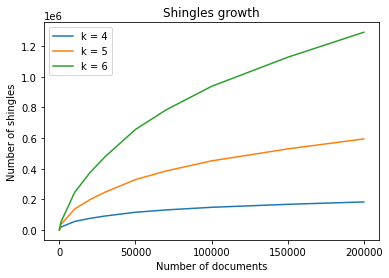

In [21]:
for k in [3, 4, 5, 6]:
    plt.plot(
        results[k]['docs'], 
        results[k]['shingles'],
        label=f'k = {k}'
    )
plt.xticks([0, 50000, 100000, 150000, 200000])
plt.xlabel('Number of documents')
plt.ylabel('Number of shingles')
plt.title('Shingles growth')
plt.legend(loc='best')
plt.savefig('img/shingles_growth.png', dpi=300)

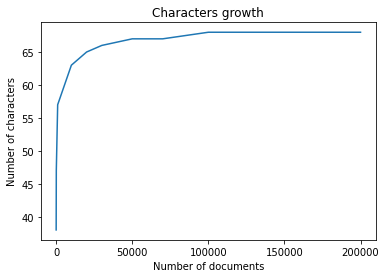

In [22]:
plt.plot(
    results[5]['docs'], 
    results[5]['characters']
)
plt.xticks([0, 50000, 100000, 150000, 200000])
plt.xlabel('Number of documents')
plt.ylabel('Number of characters')
plt.title('Characters growth')
plt.savefig('img/char_growth.png', dpi=300)

## Number of hash bits

In [29]:
results = dict()

for k in [3, 4, 5]:
    ls = []

    for n_bits in [12, 14, 16, 18, 19, 20, 22]:
        ckpt_path = f'checkpoints/k{k}_n_bits{n_bits}'
        time_path = f'{ckpt_path}/time.npy'

        model = LSHModel(
            k=k,
            threshold=0.1,
            num_hashes=100,
            shingle_hash_bits=n_bits,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()

            time_delta = np.load(
                f'{ckpt_path}/time.npy', 
                allow_pickle=True
            )

            sig_tp = dict(model.get_similar_pairs())
            
        else:
            start_time = timeit.default_timer()

            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=100,
                verbose=False,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()

            sig_tp = dict(model.get_similar_pairs())

            end_time = timeit.default_timer()
            time_delta = end_time - start_time
            np.save(f'{ckpt_path}/time.npy', time_delta)

        cm_tp, _ = model.check_threshold_on_cm()
        cm_tp = dict(cm_tp)
        num_wrong, mae = evaluate_on_cm(sig_tp, cm_tp)
        correct = len(sig_tp) - num_wrong
        ratio = correct / len(sig_tp)

        ls.append(
            (
                n_bits, 
                time_delta.item(),
                len(sig_tp),
                correct, 
                num_wrong,
                ratio,
                mae
            )
        )

        print(
            f'[k {k}, {n_bits} bits]:\n'
            f'\t{time_delta} seconds\n'
            f'\t{num_wrong} wrong out of {len(sig_tp)} \
                ({ratio} Prec.) (0.1 t)\n'
            f'\t{mae} MAE\n'
        )
    
    results[k] = pd.DataFrame(
        ls,
        columns=[
            'Hash bits', 
            'Time delta (s)', 
            'Predicted pairs',
            'Correct pairs (TP)', 
            'Wrong pairs (FP)', 
            'Correct ratio (Prec.)',
            'MAE'
        ]
    ).set_index('Hash bits')

Loaded signature from row 65535


[k 4, 16 bits]:
	31.110862200002884 seconds
	210 wrong out of 334 (0.1 t)
	0.017856006846919462 MAE

Loaded signature from row 262143


[k 4, 18 bits]:
	100.37320900000486 seconds
	69 wrong out of 177 (0.1 t)
	0.014720416712469988 MAE

Loaded signature from row 524287


[k 4, 19 bits]:
	194.69811100000516 seconds
	310 wrong out of 435 (0.1 t)
	0.028153618099080492 MAE

Loaded signature from row 1048575


[k 4, 20 bits]:
	373.5336559999996 seconds
	125 wrong out of 234 (0.1 t)
	0.01957899446464125 MAE

Loaded signature from row 4194303


[k 4, 22 bits]:
	1412.1583293000003 seconds
	92 wrong out of 185 (0.1 t)
	0.018221176550976843 MAE

Loaded signature from row 65535


[k 5, 16 bits]:
	30.373443799995584 seconds
	35 wrong out of 83 (0.1 t)
	0.014206988566897416 MAE

Loaded signature from row 262143


[k 5, 18 bits]:
	97.62258229999861 seconds
	187 wrong out of 246 (0.1 t)
	0.027488986230994862 MAE

Loaded signature from row 524287


[k 5, 19 bits]:
	184.12369390000094 seconds
	60 wrong out of 110 (0.1 t)
	0.01420768366469921 MAE

Loaded signature from row 1048575


[k 5, 20 bits]:
	354.22847639999964 seconds
	65 wrong out of 112 (0.1 t)
	0.01316891791672801 MAE

Loaded signature from row 4194303


[k 5, 22 bits]:
	1418.4705095000027 seconds
	46 wrong out of 91 (0.1 t)
	0.017326680995751933 MAE



In [39]:
for k in [3, 4, 5]:
    print(results[k].set_index('Hash bits').round(3)) 

           Time delta (s)  Predicted pairs  Wrong pairs  Wrong ratio    MAE
Hash bits                                                                  
16                 31.111              334          210        0.629  0.018
18                100.373              177           69        0.390  0.015
19                194.698              435          310        0.713  0.028
20                373.534              234          125        0.534  0.020
22               1412.158              185           92        0.497  0.018
           Time delta (s)  Predicted pairs  Wrong pairs  Wrong ratio    MAE
Hash bits                                                                  
16                 30.373               83           35        0.422  0.014
18                 97.623              246          187        0.760  0.027
19                184.124              110           60        0.545  0.014
20                354.228              112           65        0.580  0.013
22          

## Threshold choice

In [ ]:
results = dict()

for k in [3, 4, 5]:
    ls = []

    for t in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]:
        ckpt_path = f'checkpoints/k{k}_t{t}'

        model = LSHModel(
            k=k,
            threshold=t,
            num_hashes=100,
            shingle_hash_bits=16,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()
            sig_tp = dict(model.get_similar_pairs())
            
        else:
            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=100,
                verbose=False,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()
            sig_tp = dict(model.get_similar_pairs())

        cm_tp, _ = model.check_threshold_on_cm()
        cm_tp = dict(cm_tp)
        num_wrong, mae = evaluate_on_cm(sig_tp, cm_tp)
        correct = len(sig_tp) - num_wrong
        ratio = correct / len(sig_tp)

        ls.append(
            (
                t,
                len(sig_tp),
                correct, 
                num_wrong,
                ratio,
                mae
            )
        )

        print(
            f'[k {k}, {t} threshold]:\n'
            f'\t{num_wrong} wrong out of {len(sig_tp)} \
                ({ratio} Prec.) (0.1 t)\n'
            f'\t{mae} MAE\n'
        )
    
    results[k] = pd.DataFrame(
        ls,
        columns=[
            'Threshold', 
            'Predicted pairs',
            'Correct pairs (TP)', 
            'Wrong pairs (FP)', 
            'Correct ratio (Prec.)',
            'MAE'
        ]
    ).set_index('Threshold')

## 500k Tweets comparison

### Train LSH model

MORE THAN ONE MODEL?

In [165]:
ckpt_path = f'checkpoints/d100/k5_t0.1_bits16'
model = LSHModel(
    k=5,
    threshold=0.1,
    num_hashes=100,
    shingle_hash_bits=16,
    track_shingles=True,
    checkpoint_path=ckpt_path
)
model = train_model(
    model=model, 
    data_path=DATA_PATH,
    num_docs=100,
    verbose=True,
    preprocessing_pipeline=preprocessing_pipeline,
)

Adding documents to model:   0%|          | 0/100 [00:00<?, ?it/s]

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip


Found 191292 duplicates in files


In [166]:
similar_pairs = model.get_similar_pairs()

Loaded signature from row 65535


### MPNet embeddings

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    'sentence-transformers/all-mpnet-base-v2'
)
mpnet = AutoModel.from_pretrained(
    'sentence-transformers/all-mpnet-base-v2'
).to(device)

In [ ]:
mpnet_preprocessing = [
    str.lower,
    remove_https,
    replace_chars,
    normalize_white_space
]

In [168]:
idx_ls = np.unique(
    np.array(
        [
            list(pair)
            for pair, _ in similar_pairs
        ] 
    ).flatten()
)
text_dict = dict(get_text(idx_ls, DATA_PATH))

preprocessed_texts = []
for text in text_dict.values():
    for f in mpnet_preprocessing:
        text = f(text)
    preprocessed_texts.append(text)

encoded_input = tokenizer(
    preprocessed_texts, 
    padding='max_length', 
    truncation=True, 
    return_tensors='pt'
).to(device)

array([ 0,  1,  2,  4,  6,  9, 10, 12, 13, 14, 15, 16, 19, 20, 21, 23, 25,
       27, 28, 30, 31, 32, 35, 36, 37, 38, 39, 41, 43, 44, 45, 47, 49, 50,
       51, 52, 53, 57, 58, 63, 64, 66, 67, 69, 70, 71, 73, 75, 76, 77, 78,
       79, 86, 87, 89, 91, 92, 96, 97, 98])

In [236]:
with torch.no_grad():
    model_output = model(**encoded_input)

embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

embeddings_dict = {
    key: val
    for key, val in zip(text_dict.keys(), embeddings)
}

In [237]:
lsh_sims = []
mpnet_sims = []

for ((x_idx, y_idx), lsh_sim) in similar_pairs:
    lsh_sims.append(lsh_sim)
    mpnet_sims.append(
        torch_cosine_similarity(
            embeddings_dict[x_idx],
            embeddings_dict[y_idx],
        )
    )

### Compare rankings

In [239]:
kendalltau(lsh_sims, mpnet_sims)

KendalltauResult(correlation=0.4790651278562069, pvalue=9.727797364038488e-09)

In [241]:
spearmanr(lsh_sims, mpnet_sims)

SpearmanrResult(correlation=0.6255073800230813, pvalue=1.1872875150277376e-09)